In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
import corner


In [2]:
import xoflares #  the flares code

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)

0.2.4.dev69+gc063778
1.0.4
3.8


In [4]:
#  let's create some take data
#  we simulate n flares. In reality the flares enengies are distributed like a power law,
#  but that's not easy to draw from here, so we'll make the amplitudes follow a power law.
#  Inside the model, we learn the shape of the power law, in the real stars example, we want to
#  learn that function of ED, not amplitude.
# t = np.arange(0, 25, 2/1440)

np.random.seed(8675309)
# tpeaks = np.random.choice(t, size=npeaks)
# fwhms = np.random.uniform(size=npeaks, low=6/1440, high=60/1440)

a = 2.
mconst = 0.2
# ampls = pm.distributions.continuous.Pareto.dist(a, mconst).random(size=npeaks)
# lam = 2
# ampls = lam * np.exp(-np.random.uniform(size=npeaks) * lam)

scaling_constant = 1.8227218325582693

t = np.arange(0, 25, 2/1440)
npeaks = 20

tpeaks = np.random.choice(t, size=npeaks)

fwhms = np.random.uniform(size=npeaks, low=6/1440, high=60/1440)

EDs = pm.distributions.continuous.Pareto.dist(a, mconst).random(size=npeaks)

ampls = EDs / (fwhms * scaling_constant)

In [5]:
data_len = t.shape[0]

In [6]:
y = xoflares.eval_get_light_curve(t, tpeaks, fwhms ,ampls,
                                 )
y_orig = np.copy(y)
yerr = 1 * np.ones_like(y)
y +=  np.random.normal(scale=yerr, size=np.shape(t)[0])
x = np.copy(t)

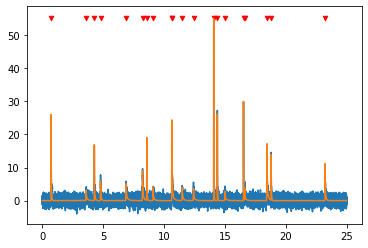

In [7]:
plt.plot(t, y)
plt.plot(t, xoflares.eval_get_light_curve(t, tpeaks, fwhms ,ampls))
plt.scatter(tpeaks, np.zeros_like(tpeaks) + np.max(ampls), color='r', s=20, marker='v')

In [8]:
tpeaks_d = np.copy(tpeaks)
fwhms_d = np.copy(fwhms)
ampls_d = np.copy(ampls)
EDs_d = np.copy(EDs)
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        BoundedNormal = pm.Bound(pm.Normal, lower=0)
        xval = pm.Data('xval', x[mask])
        data = pm.Data('data', y[mask])
        data_err = pm.Data('data_err', yerr[mask])

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0, sd=2.0)

#        prior on the flare energies, loglike of pareto dist
        logalpha = pm.Normal('logalpha', mu=np.log(a), sd=1, testval=np.log(a))
        alpha = pm.Deterministic('alpha', tt.exp(logalpha))
        
#         m = BoundedNormal('m', mu=mconst, sd=0.01, testval=mconst)
        m = pm.Deterministic('m', tt.as_tensor_variable(0.01))
        ED_days = pm.Pareto('ED_days', alpha=alpha, m=m, shape=npeaks, testval=EDs_d)
        
        tpeak = BoundedNormal("tpeak", mu=tpeaks_d, sd=0.003,
                      testval=tpeaks_d, shape=npeaks)

        
#         logFwhm = pm.Normal("logFwhm", mu=tt.log(fwhms_d), sd=0.1, testval=tt.log(fwhms_d),
#                         shape=npeaks)
#         fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
        
#         ampl = pm.Deterministic("ampl", ED_days / (fwhm * scaling_constant))
        logAmpl = pm.Normal("logAmpl", mu=tt.log(ampls_d), sd=1, testval=tt.log(ampls_d),
                        shape=npeaks)
        ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
        fwhm = pm.Deterministic("fwhm", ED_days / (ampl * scaling_constant))
     
        light_curve = xoflares.get_light_curve(xval, tpeak, fwhm, ampl, oversample=7, texp=None)

        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curve

        pm.Normal('obs', mu=light_curve + mean, sd=data_err, observed=data,
                 total_size=data_len)

#         ED_days = xoflares.multiflareintegral(fwhm, ampl)
#         pm.Deterministic("ED_days", ED_days)
    
        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])

        map_soln = xo.optimize(start=map_soln, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[logalpha])


#         map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
#         map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
#         map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
#         map_soln = xo.optimize(start=map_soln, vars=[tpeak])
#         map_soln = xo.optimize(start=map_soln, vars=[tpeak,fwhm, ampl])
    return model, map_soln

model0, map_soln0 = build_model()
print(model0.check_test_point())

optimizing logp for variables: [mean]
5it [00:01,  2.55it/s, logp=-2.556532e+04] 
message: Optimization terminated successfully.
logp: -25565.41670689882 -> -25565.319404223013
optimizing logp for variables: [mean, ED_days, logAmpl]
81it [00:02, 31.98it/s, logp=-2.554714e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -25565.319404223013 -> -25547.13919768178
optimizing logp for variables: [mean, logAmpl]
87it [00:02, 36.86it/s, logp=-2.554423e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -25547.13919768178 -> -25544.22960136545
optimizing logp for variables: [logAmpl, ED_days]
70it [00:01, 39.24it/s, logp=-2.554366e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -25544.22960136545 -> -25543.55868260054
optimizing logp for variables: [tpeak]
136it [00:02, 47.35it/s, logp=-2.553833e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -25543.55868260054 -> 

mean                       -1.61
logalpha                   -0.92
ED_days_lowerbound__     -125.65
tpeak_lowerbound__        142.54
logAmpl                   -18.38
obs                    -25561.40
Name: Log-probability of test_point, dtype: float64


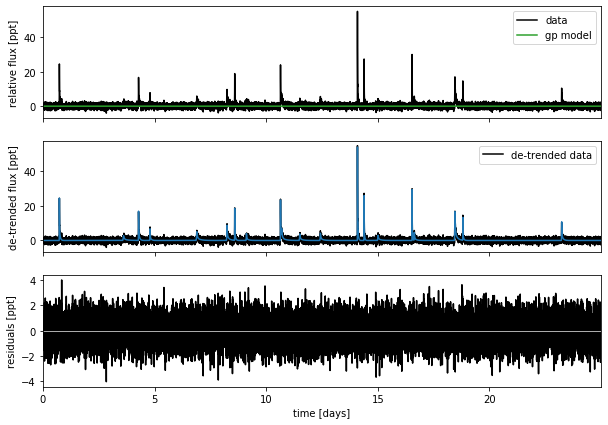

In [9]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = np.ones_like(x[mask]) * soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curve = xo.utils.eval_in_model(model.light_curves, soln, model=model)

    mod = light_curve
    ax.plot(x[mask], mod,)
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + light_curve
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

optimizing logp for variables: [mean]
3it [00:00,  3.18it/s, logp=-2.546076e+04]
message: Optimization terminated successfully.
logp: -25460.759156163298 -> -25460.759156163298
optimizing logp for variables: [mean, ED_days, logAmpl]
72it [00:01, 40.15it/s, logp=-2.545993e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -25460.759156163298 -> -25459.928678895987
optimizing logp for variables: [mean, logAmpl]
61it [00:01, 37.82it/s, logp=-2.545999e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -25459.928678895987 -> -25459.91505857
optimizing logp for variables: [logAmpl, ED_days]
83it [00:01, 42.09it/s, logp=-2.545957e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -25459.91505857 -> -25459.551138536488
optimizing logp for variables: [tpeak]
59it [00:01, 29.79it/s, logp=-2.545933e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -25459.551138536488 -> -25

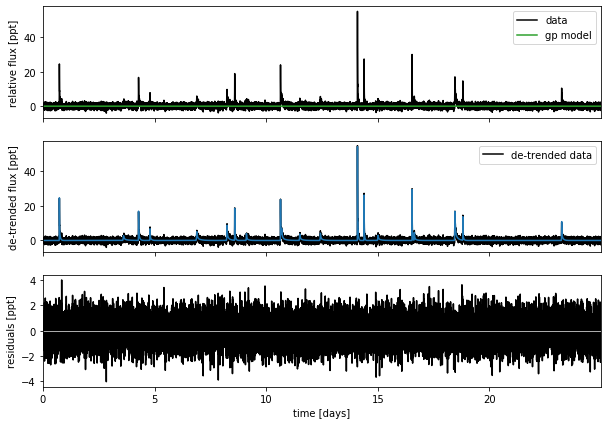

In [10]:
model, map_soln1 = build_model(mask=None, start=map_soln0)
fig = plot_light_curve(model, map_soln1, mask=None)

In [11]:
with model:
    map_soln2 = xo.optimize(start=map_soln1,)

optimizing logp for variables: [logAmpl, tpeak, ED_days, logalpha, mean]
109it [00:02, 41.59it/s, logp=-2.545902e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -25459.30389167355 -> -25459.02223233684


In [ ]:
with model:

    trace = pm.sample(tune=1500, draws=1000, start=map_soln2, chains=4,
                      step=xo.get_dense_nuts_step(target_accept=0.9),
                     )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logAmpl, tpeak, ED_days, logalpha, mean]
Sampling 4 chains, 0 divergences:  93%|█████████▎| 9304/10000 [100:58:03<1:11:30,  6.16s/draws]     

In [ ]:
pm.summary(
    trace, var_names=["logalpha", "mean", "alpha",]
)

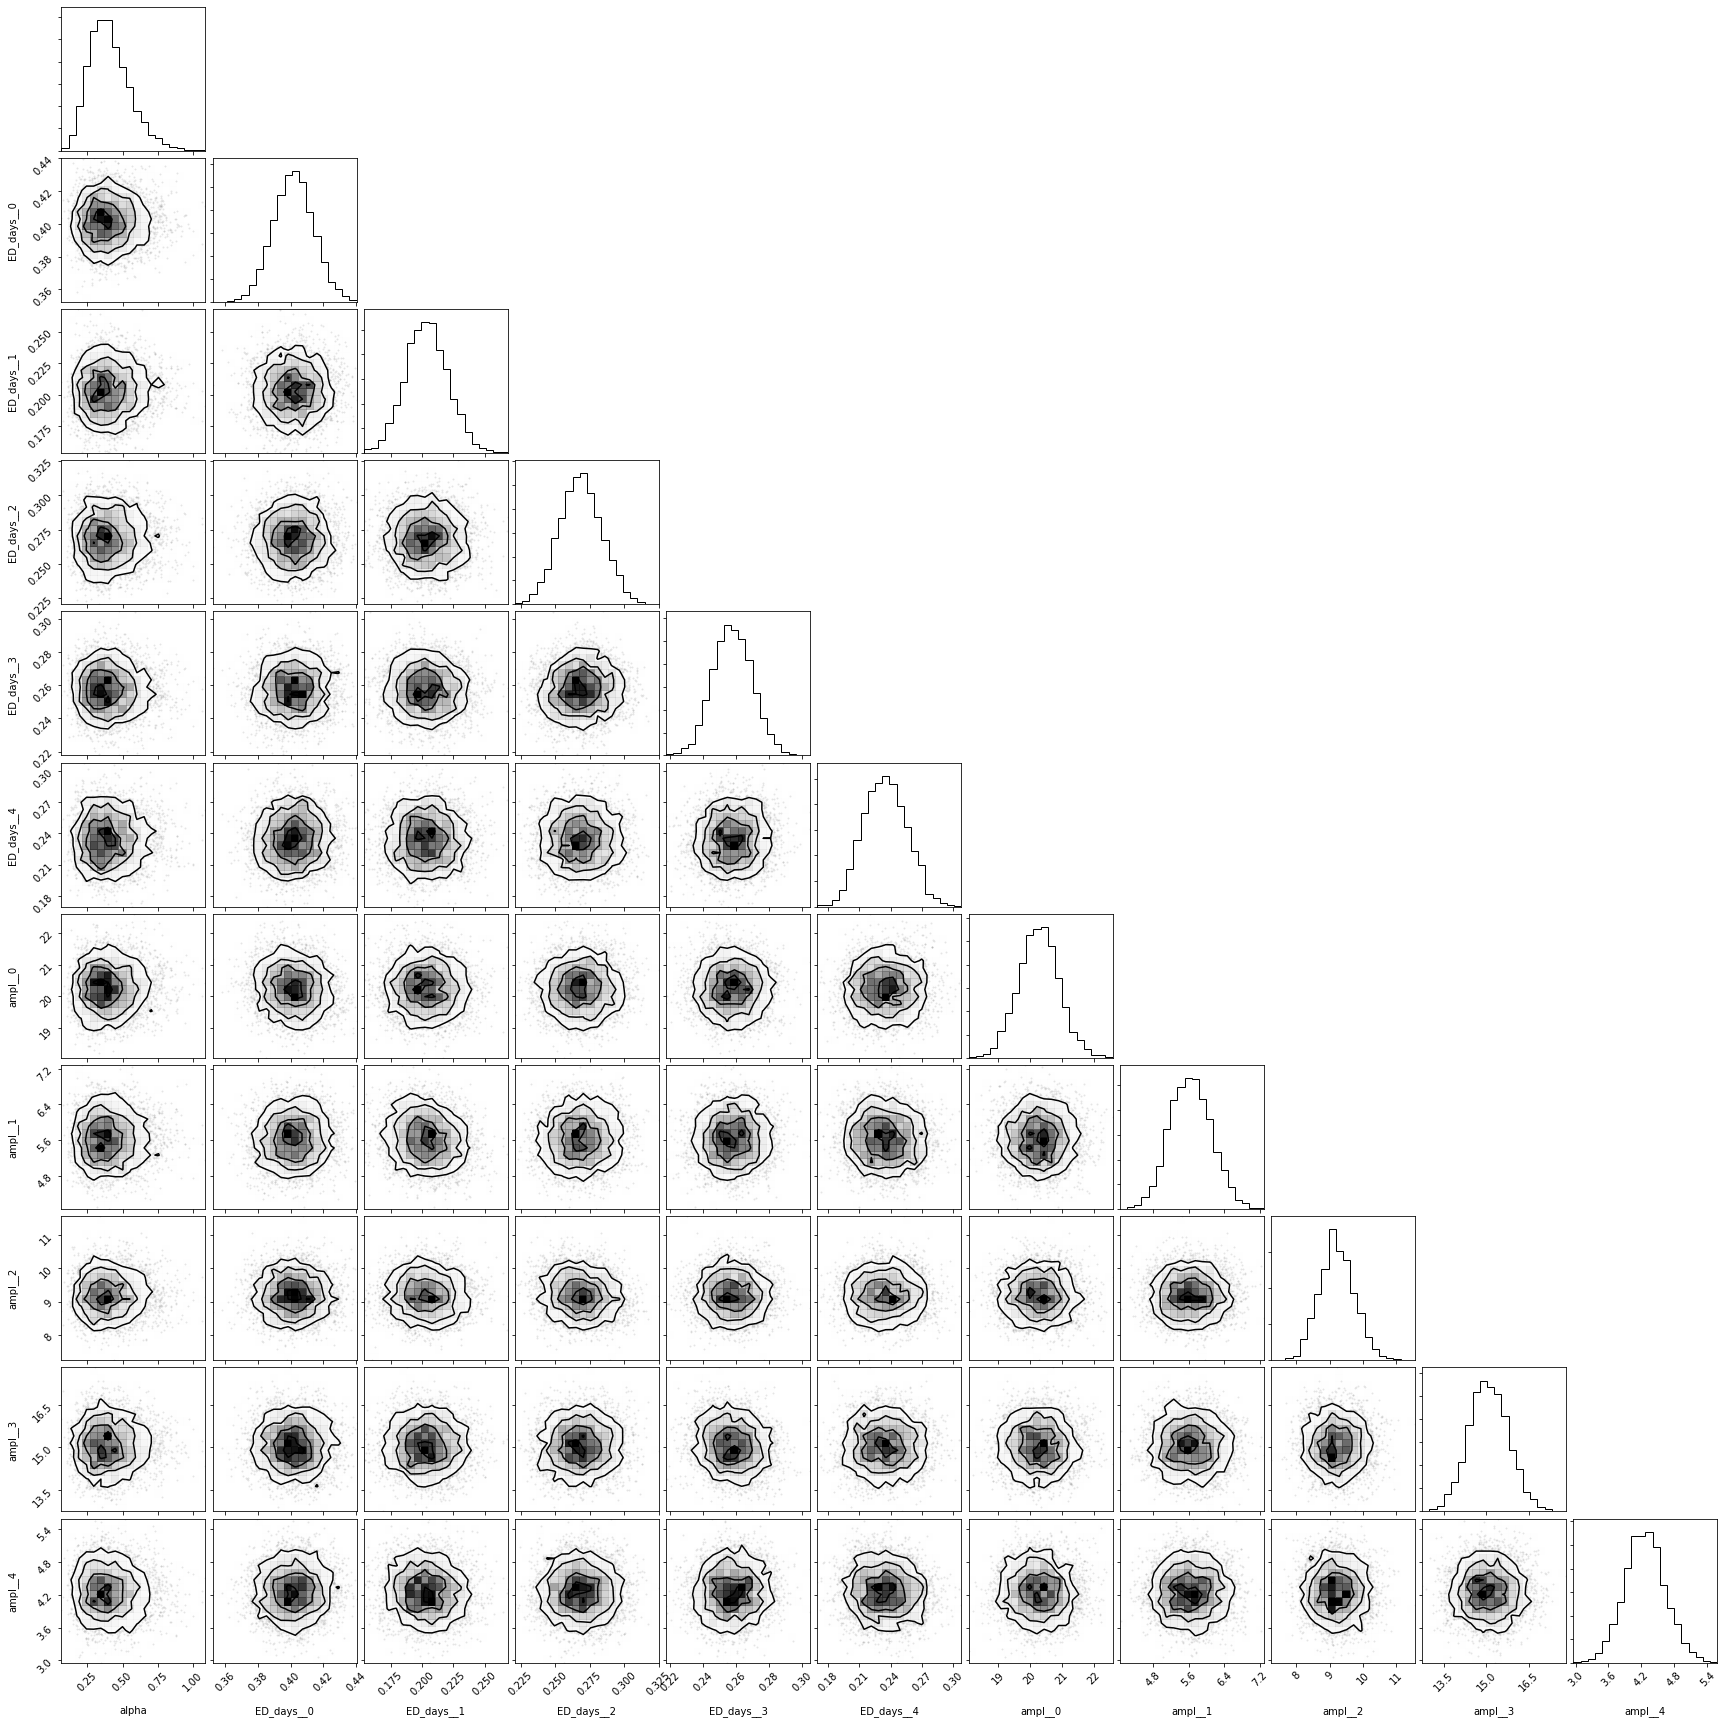

In [16]:
samples = pm.trace_to_dataframe(trace, varnames=["logalpha", "ED_days", "ampl"])

_ = corner.corner(samples)

/Users/tsbarcl2/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]


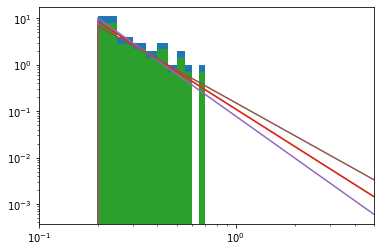

In [57]:

from scipy.stats import pareto

plt.hist(np.mean(trace['ED_days'], axis=0), bins=np.arange(0,1,0.05), );
v = np.arange(0.01, 5, 0.0001)
plt.plot(v, pareto.pdf(v, np.mean(trace['alpha']), scale=np.mean(trace['m'])))

plt.xlim(0,1)



from scipy.stats import pareto

plt.hist(np.mean(trace['ED_days'], axis=0), bins=np.arange(0,1,0.05), normed=True);
v = np.arange(0.01, 5, 0.0001)
plt.plot(v, pareto.pdf(v, np.mean(trace['alpha']), scale=np.mean(trace['m'])))
plt.plot(v, pareto.pdf(v, np.mean(trace['alpha'])+np.std(trace['alpha']), scale=np.mean(trace['m'])))
plt.plot(v, pareto.pdf(v, np.mean(trace['alpha'])-np.std(trace['alpha']), scale=np.mean(trace['m'])))

plt.xlim(0.1,5)

plt.yscale('log')
plt.xscale('log')

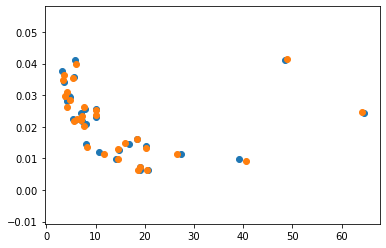

In [28]:
plt.scatter(np.mean(trace['ampl'], axis=0), np.mean(trace['fwhm'], axis=0))
plt.scatter(ampls, fwhms, )

In [31]:
np.mean(trace['ampl'])

14.353819477583393

In [33]:
np.mean(trace['ED_days'], axis=0)

array([0.12037575, 0.24754129, 0.22636425, 0.1555844 , 0.13912492,
       0.11568314, 0.16206851, 0.11800483, 0.17987141, 0.24055696,
       0.37016549, 0.18790465, 0.11634944, 0.11799234, 0.19583944,
       0.11964544, 0.23110608, 0.16355198, 0.1361742 , 0.44628655])

In [20]:
EDs

array([0.21848542, 0.46227056, 0.42187344, 0.29195   , 0.2588723 ,
       0.20139456, 0.29885718, 0.2166609 , 0.3385117 , 0.44206593,
       0.69061372, 0.38001264, 0.21624323, 0.20705499, 0.35641443,
       0.21820964, 0.39571526, 0.29975702, 0.25155824, 0.81894164])

NameError: name 'v' is not defined